<a href="https://colab.research.google.com/github/marcogemaque/COVID-19-Breathers/blob/main/Mechanical_Ventilator_COVID_19_Notebook_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**A Duck's Dream**

### **Breathers on COVID-19 - Wrangling**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_real = pd.read_csv("/content/drive/My Drive/A Duck's Dream/distribuicao_respiradores.csv", sep=';')

In [4]:
df = df_real.copy()
df.head()

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA
0,19/04/2020,VYAIRE,RIO DE JANEIRO,ESTADO,UTI,40,"2400000,00",ALMOXARIFADO ESTADUAL DE MEDICAMENTOS - RIO DE...,RJ,19/04/2020
1,22/04/2020,VYAIRE,RIO DE JANEIRO,ESTADO,UTI,20,"1200000,00",LABORATÓRIO QUÍMICO FARMACÊUTICO DE AERONÁUTICA,RJ,23/04/2020
2,08/05/2020,MAGNAMED,RIO DE JANEIRO,ESTADO,UTI,25,"1500000,00",ALMOXARIFADO ESTADUAL DE MEDICAMENTOS - RIO DE...,RJ,09/05/2020
3,08/05/2020,KTK,RIO DE JANEIRO,ESTADO,UTI,15,"900000,00",ALMOXARIFADO ESTADUAL DE MEDICAMENTOS - RIO DE...,RJ,09/05/2020
4,09/05/2020,LEISTUNG,RIO DE JANEIRO,ESTADO,UTI,6,"360000,00",ALMOXARIFADO ESTADUAL DE MEDICAMENTOS - RIO DE...,RJ,09/05/2020


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DATA              1647 non-null   object
 1   FORNECEDOR        1647 non-null   object
 2   DESTINO           1647 non-null   object
 3   ESTADO/MUNICIPIO  1647 non-null   object
 4   TIPO              1647 non-null   object
 5   QUANTIDADE        1647 non-null   int64 
 6   VALOR             1647 non-null   object
 7   DESTINATARIO      1647 non-null   object
 8   UF                1647 non-null   object
 9   DATA DE ENTREGA   1647 non-null   object
dtypes: int64(1), object(9)
memory usage: 128.8+ KB


In [6]:
df['VALOR'] = df['VALOR'].str.replace(',','.')
df['VALOR'] = pd.to_numeric(df['VALOR'], errors='coerce')
df.tail()

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA
1642,24/09/2020,VYAIRE LTV 2200 USA,PARANA,MUNICIPIO,TRANSPORTE USA,1,63125.97,SMS de GUAIRA,PR,28/09/2020
1643,08/10/2020,VYAIRE LTV 2200 USA,PARANA,ESTADO,TRANSPORTE USA,20,1262519.40,5o Batalhao de Suprimento,PR,17/10/2020
1644,08/10/2020,MAGNAMED,PARANA,ESTADO,UTI,4,240000.00,5o Batalhao de Suprimento,PR,17/10/2020
1645,16/10/2020,MAGNAMED,PARANA,MUNICIPIO,UTI,1,60000.00,SMS de WENCESLAU BRAZ,PR,21/10/2020
1646,07/08/2020,MAGNAMED,LIBANO,-,TRANSPORTE,300,14487000.00,MISSÃO FAB (Doação Destino ao Libano).,-,08/08/2020


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATA              1647 non-null   object 
 1   FORNECEDOR        1647 non-null   object 
 2   DESTINO           1647 non-null   object 
 3   ESTADO/MUNICIPIO  1647 non-null   object 
 4   TIPO              1647 non-null   object 
 5   QUANTIDADE        1647 non-null   int64  
 6   VALOR             1647 non-null   float64
 7   DESTINATARIO      1647 non-null   object 
 8   UF                1647 non-null   object 
 9   DATA DE ENTREGA   1647 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 128.8+ KB


In [8]:
df_date = df['DATA'].str.contains('[0-9]{2}.[0-9]{2}.[0-9]{4}')
df_date = df_date.loc[df_date == False]
df_date

300     False
837     False
1503    False
Name: DATA, dtype: bool

In [9]:
sel = df.iloc[[300, 837, 1503]]
sel

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA
300,ESTADO,WEG,DISTRITO FEDERAL,ESTADO,UTI,25,1500000.0,Secretaria Estadual de Saúde,DF,10/06/2020
837,2020-04-30 00:00:00,LEISTUNG,PARA,ESTADO,UTI,60,3600000.0,Secretaria Estadual de Saúde,PA,31/04/2020
1503,16/10/M2020,MAGNAMED,RIO GRANDE DO SUL,MUNICIPIO,UTI,1,60000.0,SECR MUN DE SAUDE DE MUCUM RS,RS,21/10/2020


In [10]:
#One way to do it
df.at[837,'DATA'] = '30/04/2020'
df.at[1503,'DATA'] = '16/10/2020'

In [11]:
df_date = df['DATA DE ENTREGA'].str.contains('[0-9]{2}.[0-9]{2}.[0-9]{4}')
df_date = df_date.loc[df_date == False]
df_date

Series([], Name: DATA DE ENTREGA, dtype: bool)

In [12]:
df_date = pd.to_datetime(df['DATA DE ENTREGA'], errors='coerce')
error = df_date.loc[df_date.isnull()]
error

837   NaT
Name: DATA DE ENTREGA, dtype: datetime64[ns]

In [13]:
df.loc[[837]]

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA
837,30/04/2020,LEISTUNG,PARA,ESTADO,UTI,60,3600000.0,Secretaria Estadual de Saúde,PA,31/04/2020


In [14]:
df.at[837,'DATA DE ENTREGA'] = '01/05/2020'

In [15]:
#Create a dataframe that excludes our broken data for calculating delay
df_delay = df.copy()
df_delay = df_delay.drop([300],axis=0)
df_delay['DATA DE ENTREGA'] = pd.to_datetime(df_delay['DATA DE ENTREGA'], format="%d/%m/%Y")
df_delay['DATA'] = pd.to_datetime(df_delay['DATA'], format="%d/%m/%Y")
df_delay['DELAY'] = df_delay['DATA DE ENTREGA'] - df_delay['DATA']
sorted = df_delay.sort_values(by='DELAY')
sorted.head()

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA,DELAY
829,2020-06-02,MAGNAMED,RORAIMA,ESTADO,TRANSPORTE,15,724350.0,Secretaria Estadual de Saúde,RR,2020-04-01,-62 days
828,2020-06-02,VYAIRE,RORAIMA,ESTADO,UTI,15,900000.0,Secretaria Estadual de Saúde,RR,2020-04-01,-62 days
0,2020-04-19,VYAIRE,RIO DE JANEIRO,ESTADO,UTI,40,2400000.0,ALMOXARIFADO ESTADUAL DE MEDICAMENTOS - RIO DE...,RJ,2020-04-19,0 days
1299,2020-06-25,KTK,SÃO PAULO,ESTADO,UTI,10,600000.0,Secretaria Estadual de Saúde,SP,2020-06-25,0 days
29,2020-06-08,KTK,RIO DE JANEIRO,ESTADO,TRANSPORTE,50,1000000.0,ALMOXARIFADO ESTADUAL DE MEDICAMENTOS - RIO DE...,RJ,2020-06-08,0 days


In [16]:
#Exclude the shitty columns 829 and 828
df_delay = df_delay.drop([828,829], axis=0)
df_delay.head()

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA,DELAY
0,2020-04-19,VYAIRE,RIO DE JANEIRO,ESTADO,UTI,40,2400000.0,ALMOXARIFADO ESTADUAL DE MEDICAMENTOS - RIO DE...,RJ,2020-04-19,0 days
1,2020-04-22,VYAIRE,RIO DE JANEIRO,ESTADO,UTI,20,1200000.0,LABORATÓRIO QUÍMICO FARMACÊUTICO DE AERONÁUTICA,RJ,2020-04-23,1 days
2,2020-05-08,MAGNAMED,RIO DE JANEIRO,ESTADO,UTI,25,1500000.0,ALMOXARIFADO ESTADUAL DE MEDICAMENTOS - RIO DE...,RJ,2020-05-09,1 days
3,2020-05-08,KTK,RIO DE JANEIRO,ESTADO,UTI,15,900000.0,ALMOXARIFADO ESTADUAL DE MEDICAMENTOS - RIO DE...,RJ,2020-05-09,1 days
4,2020-05-09,LEISTUNG,RIO DE JANEIRO,ESTADO,UTI,6,360000.0,ALMOXARIFADO ESTADUAL DE MEDICAMENTOS - RIO DE...,RJ,2020-05-09,0 days


In [17]:
df_delay.describe()

,QUANTIDADE,VALOR,DELAY
count,1644.000000,1.644000e+03,1644
mean,7.272506,3.797893e+05,5 days 08:00:52.554744525
std,13.743497,7.410215e+05,3 days 11:22:24.755114401
min,1.000000,2.000000e+04,0 days 00:00:00
25%,2.000000,6.000000e+04,3 days 00:00:00
50%,3.000000,1.448700e+05,5 days 00:00:00
75%,7.000000,3.600000e+05,7 days 00:00:00
max,300.000000,1.448700e+07,32 days 00:00:00


In [18]:
mapper = {"KTK/VAYIRE":"KTK","LEISTUNG/VYAIRE":"LEISTUNG","Leistung":"LEISTUNG","MAGNAMED-REQUISIÇÃO":"MAGNAMED",
          "MAGNAMED/REQUISIÇÃO":"MAGNAMED","SUZANO/RESMED":"SUZANO","SUZANO/Resmed":"SUZANO","SUZANO/Zhongxun Medical":"SUZANO",
          "VYAIRE LTV 1200 USA":"VYAIRE", "VYAIRE LTV 2200 USA":"VYAIRE"}

df['FORNECEDOR'] = df['FORNECEDOR'].replace(mapper)
df.tail()

,DATA,FORNECEDOR,DESTINO,ESTADO/MUNICIPIO,TIPO,QUANTIDADE,VALOR,DESTINATARIO,UF,DATA DE ENTREGA
1642,24/09/2020,VYAIRE,PARANA,MUNICIPIO,TRANSPORTE USA,1,63125.97,SMS de GUAIRA,PR,28/09/2020
1643,08/10/2020,VYAIRE,PARANA,ESTADO,TRANSPORTE USA,20,1262519.40,5o Batalhao de Suprimento,PR,17/10/2020
1644,08/10/2020,MAGNAMED,PARANA,ESTADO,UTI,4,240000.00,5o Batalhao de Suprimento,PR,17/10/2020
1645,16/10/2020,MAGNAMED,PARANA,MUNICIPIO,UTI,1,60000.00,SMS de WENCESLAU BRAZ,PR,21/10/2020
1646,07/08/2020,MAGNAMED,LIBANO,-,TRANSPORTE,300,14487000.00,MISSÃO FAB (Doação Destino ao Libano).,-,08/08/2020


## **Exploratory Data Analysis**

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'ACRE'),
 Text(0, 0, 'ALAGOAS'),
 Text(0, 0, 'AMAPA'),
 Text(0, 0, 'AMAZONAS'),
 Text(0, 0, 'BAHIA'),
 Text(0, 0, 'CEARA'),
 Text(0, 0, 'DISTRITO FEDERAL'),
 Text(0, 0, 'ESPIRITO SANTO '),
 Text(0, 0, 'GOIAS'),
 Text(0, 0, 'LIBANO'),
 Text(0, 0, 'MARANHÃO'),
 Text(0, 0, 'MATO GROSSO '),
 Text(0, 0, 'MATO GROSSO DO SUL'),
 Text(0, 0, 'MINAS GERAIS'),
 Text(0, 0, 'PARA'),
 Text(0, 0, 'PARAIBA'),
 Text(0, 0, 'PARANA'),
 Text(0, 0, 'PERNAMBUCO'),
 Text(0, 0, 'PIAUI'),
 Text(0, 0, 'RIO DE JANEIRO'),
 Text(0, 0, 'RIO GRANDE DO NORTE'),
 Text(0, 0, 'RIO GRANDE DO SUL '),
 Text(0, 0, 'RONDONIA'),
 Text(0, 0, 'RORAIMA'),
 Text(0, 0, 'SANTA CATARINA'),
 Text(0, 0, 'SERGIPE'),
 Text(0, 0, 'SÃO PAULO'),
 Text(0, 0, 'TOCANTINS')]

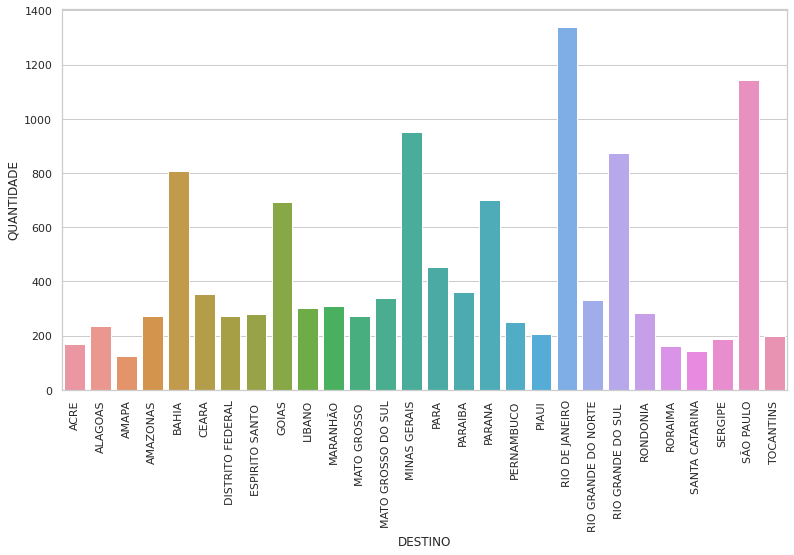

In [20]:
breath_by_state = df.groupby(['DESTINO'])['QUANTIDADE'].sum()
sns.set(style="whitegrid")
sns.set_palette("pastel")
plt.figure(figsize=(13,7))
ax = sns.barplot(breath_by_state.index, breath_by_state)
ax.set_xticklabels(labels=breath_by_state.index, rotation=90)

In [21]:
mean_by_breather = df['VALOR'].sum()/df['QUANTIDADE'].sum()
print('Your average breather was acquired by {} reais'.format(round(mean_by_breather)))

Your average breather was acquired by 52244.0 reais


[Text(0, 0, 'ACRE'),
 Text(0, 0, 'ALAGOAS'),
 Text(0, 0, 'AMAPA'),
 Text(0, 0, 'AMAZONAS'),
 Text(0, 0, 'BAHIA'),
 Text(0, 0, 'CEARA'),
 Text(0, 0, 'DISTRITO FEDERAL'),
 Text(0, 0, 'ESPIRITO SANTO '),
 Text(0, 0, 'GOIAS'),
 Text(0, 0, 'LIBANO'),
 Text(0, 0, 'MARANHÃO'),
 Text(0, 0, 'MATO GROSSO '),
 Text(0, 0, 'MATO GROSSO DO SUL'),
 Text(0, 0, 'MINAS GERAIS'),
 Text(0, 0, 'PARA'),
 Text(0, 0, 'PARAIBA'),
 Text(0, 0, 'PARANA'),
 Text(0, 0, 'PERNAMBUCO'),
 Text(0, 0, 'PIAUI'),
 Text(0, 0, 'RIO DE JANEIRO'),
 Text(0, 0, 'RIO GRANDE DO NORTE'),
 Text(0, 0, 'RIO GRANDE DO SUL '),
 Text(0, 0, 'RONDONIA'),
 Text(0, 0, 'RORAIMA'),
 Text(0, 0, 'SANTA CATARINA'),
 Text(0, 0, 'SERGIPE'),
 Text(0, 0, 'SÃO PAULO'),
 Text(0, 0, 'TOCANTINS')]

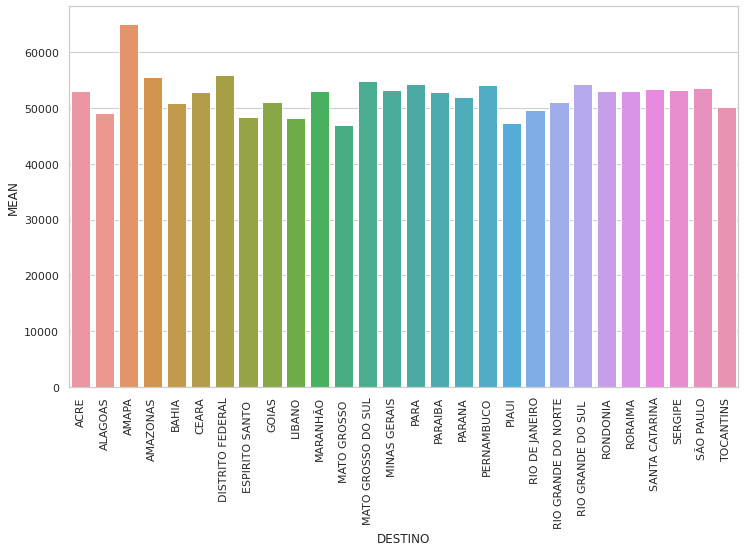

In [22]:
group_by_quant = df.groupby(['DESTINO'])['QUANTIDADE'].sum()
group_by_value = df.groupby(['DESTINO'])['VALOR'].sum()
mean_by_state = pd.DataFrame(group_by_quant)
mean_by_state['VALOR'] = group_by_value
mean_by_state['MEAN'] = mean_by_state['VALOR']/mean_by_state['QUANTIDADE']
plt.figure(figsize=(12,7))
ax = sns.barplot(x=mean_by_state.index, y=mean_by_state['MEAN'])
ax.set_xticklabels(labels=breath_by_state.index, rotation=90)

In [23]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1644 entries, 0 to 1646
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   DATA              1644 non-null   datetime64[ns] 
 1   FORNECEDOR        1644 non-null   object         
 2   DESTINO           1644 non-null   object         
 3   ESTADO/MUNICIPIO  1644 non-null   object         
 4   TIPO              1644 non-null   object         
 5   QUANTIDADE        1644 non-null   int64          
 6   VALOR             1644 non-null   float64        
 7   DESTINATARIO      1644 non-null   object         
 8   UF                1644 non-null   object         
 9   DATA DE ENTREGA   1644 non-null   datetime64[ns] 
 10  DELAY             1644 non-null   timedelta64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(6), timedelta64[ns](1)
memory usage: 154.1+ KB


[Text(0, 0, 'ACRE'),
 Text(0, 0, 'ALAGOAS'),
 Text(0, 0, 'AMAPA'),
 Text(0, 0, 'AMAZONAS'),
 Text(0, 0, 'BAHIA'),
 Text(0, 0, 'CEARA'),
 Text(0, 0, 'DISTRITO FEDERAL'),
 Text(0, 0, 'ESPIRITO SANTO '),
 Text(0, 0, 'GOIAS'),
 Text(0, 0, 'LIBANO'),
 Text(0, 0, 'MARANHÃO'),
 Text(0, 0, 'MATO GROSSO '),
 Text(0, 0, 'MATO GROSSO DO SUL'),
 Text(0, 0, 'MINAS GERAIS'),
 Text(0, 0, 'PARA'),
 Text(0, 0, 'PARAIBA'),
 Text(0, 0, 'PARANA'),
 Text(0, 0, 'PERNAMBUCO'),
 Text(0, 0, 'PIAUI'),
 Text(0, 0, 'RIO DE JANEIRO'),
 Text(0, 0, 'RIO GRANDE DO NORTE'),
 Text(0, 0, 'RIO GRANDE DO SUL '),
 Text(0, 0, 'RONDONIA'),
 Text(0, 0, 'RORAIMA'),
 Text(0, 0, 'SANTA CATARINA'),
 Text(0, 0, 'SERGIPE'),
 Text(0, 0, 'SÃO PAULO'),
 Text(0, 0, 'TOCANTINS')]

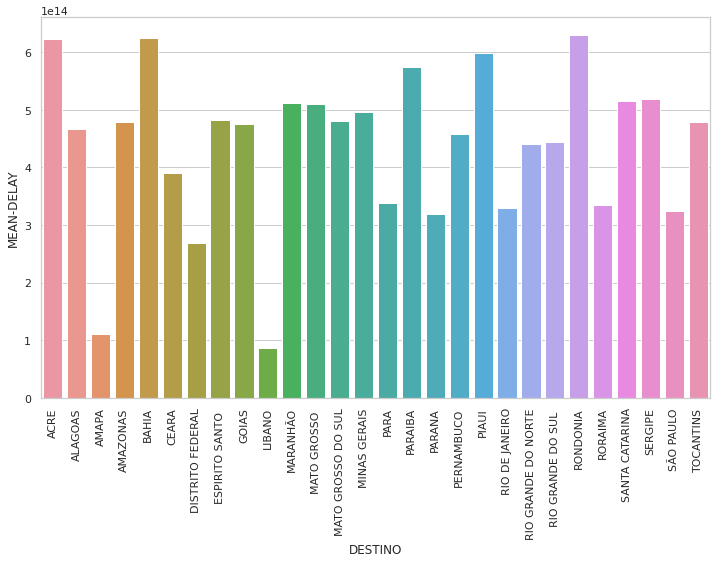

In [34]:
total_state = df_delay.groupby(['DESTINO'])['DESTINO'].count()
delay_by_state = df_delay.groupby(['DESTINO'])['DELAY'].sum()
df_delay_by_delivery = pd.DataFrame(total_state)
df_delay_by_delivery['DELAY'] = delay_by_state
df_delay_by_delivery['MEAN-DELAY'] = df_delay_by_delivery['DELAY']/df_delay_by_delivery['DESTINO']
df_delay_by_delivery['MEAN-DELAY'] = pd.to_numeric(df_delay_by_delivery['MEAN-DELAY'])
sns.set(style="whitegrid")
sns.set_palette('colorblind')
plt.figure(figsize=(12,7))
ax = sns.barplot(x=df_delay_by_delivery.index, y=df_delay_by_delivery['MEAN-DELAY'])
ax.set_xticklabels(labels=breath_by_state.index, rotation=90)

In [47]:
breath_by_supp = df.groupby(['FORNECEDOR','DESTINO'])['QUANTIDADE'].sum()
cost_by_supp_state = df.groupby(['FORNECEDOR','DESTINO'])['VALOR'].sum()
df_bbs = pd.DataFrame(breath_by_supp)
df_bbs.to_html('temp.html')

In [53]:
df_bcss = pd.DataFrame(breath_by_supp)
df_bcss['VALOR'] = cost_by_supp_state
df_bcss['MEAN'] = df_bcss['VALOR']/df_bcss['QUANTIDADE']
df_bcss.to_html('cost_by_supp_by_state.html')